# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [81]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

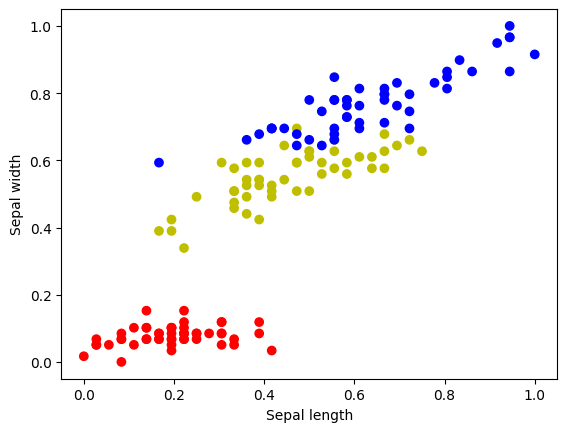

In [82]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [83]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [84]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [85]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [86]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.6034,  0.5240],
                      [ 0.6511,  0.6834],
                      [-0.1033,  0.3194]])),
             ('bias', tensor([-0.1736,  0.4370, -0.1718]))])

### Fazendo um predict

In [87]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[-0.2722,  0.6280, -0.1731],
        [-0.2386,  0.5919, -0.1673],
        [-0.2140,  0.5441, -0.1670],
        [-0.1795,  0.5492, -0.1533]], grad_fn=<AddmmBackward0>)

In [88]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.2191, 0.5390, 0.2419],
        [0.2289, 0.5252, 0.2458],
        [0.2391, 0.5103, 0.2506],
        [0.2440, 0.5056, 0.2504]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [89]:
F.softmax(out,dim=1)*100

tensor([[21.9091, 53.8992, 24.1917],
        [22.8915, 52.5247, 24.5838],
        [23.9098, 51.0297, 25.0604],
        [24.3971, 50.5589, 25.0441]], grad_fn=<MulBackward0>)

### Predição da classe

In [90]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([1, 1, 1, 1])
tensor([0.5390, 0.5252, 0.5103, 0.5056], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [91]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [92]:
lr = 3.1

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.08496438711881638


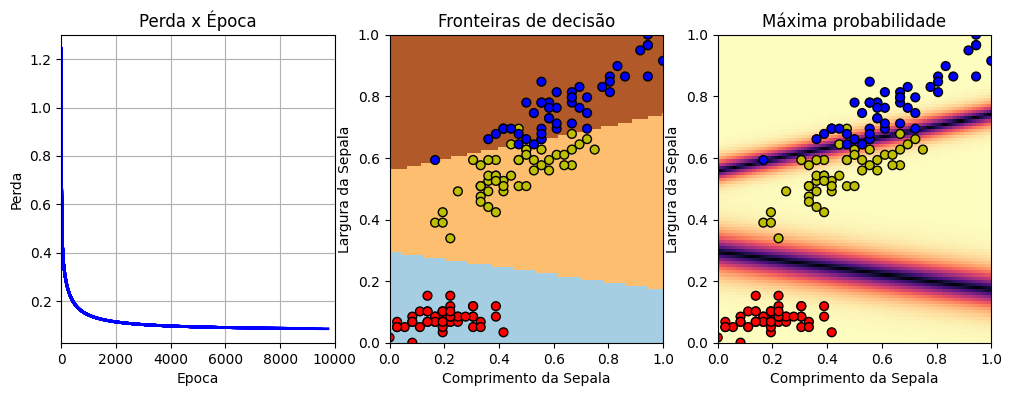

In [93]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [94]:
model.state_dict()

OrderedDict([('weight',
              tensor([[  0.9044, -40.8750],
                      [  4.8479,  -8.1127],
                      [ -5.8079,  50.5136]])),
             ('bias', tensor([ 17.3934,   7.7357, -25.0369]))])

### Salvando os parâmetros treinados

In [95]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [96]:
! ls ../models/

RegrLog_Iris.pt


In [97]:
nn.init.constant(model.weight,0)
model.state_dict()

<ipython-input-97-0d5512203613>:1: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 17.3934,   7.7357, -25.0369]))])

### Recuperando os pesos salvos

In [98]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[  0.9044, -40.8750],
                      [  4.8479,  -8.1127],
                      [ -5.8079,  50.5136]])),
             ('bias', tensor([ 17.3934,   7.7357, -25.0369]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [99]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.9666666666666667


### Matriz de confusão

In [100]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,2
2,0,3,48


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

Resposta: Redefinir os pesos novamente na função "model = nn.Linear(2,3)". Mas também as outras funções serão necessárias:


*   out = model(Variable(X_tensor[:4,:]))
*   oo = F.softmax(out,dim=1)
*   prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
*   ...

2. Experimente refazer o treinamento com diferentes valores de learning rate

Resposta:



*   Com lr = 0.45 o gráfico mostra uma curva mais acentuada e o valor da perda fica abaixo que o lr = 0.15
*   Com lr = 3.1 o gráfico mostra que a linha se torna mais agressiva e a perda fica menor que o exemplo anterior. De acordo com a aula, possibilidade de overfiting



### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?

Resposta: A amostra vermelha mais próxima de (0.0,0.0).
    
    2. Qual é a amostra classificada erradamente, com maior probabilidade?

Resposta: A amostra verde no eixo (0.7,0.5).
    
    3. Qual é a amostra classificada corretamente, com menor probabilidade?

Resposta: As que estão na linha de probabilidade na altura do y = 0.6

    4. Qual é a amostra classificada erradamente, com menor probabilidade?

Resposta: As que estão na linha de probabilidade na altura do y = 0.6

2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?

Resposta: 6 pesos e 3 bias totalizando 9 parâmetros

3. Quantas entradas e quantas saídas esta rede possui?

Resposta: 2 entradas e 3 saídas

4. Como se pode calcular a acurácia a partir da matriz de confusão?

Resposta: Somando os valores dos verdadeiros positivos (diagonal principal) e dividindo pelo total de amostras.

acurácia = (50+47+48)/150.
acurácia = 0,9666

5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

Resposta: Retorna o valor máximo de todos os elementos no input tensor. Essa função retorna dois parâmetros:

*   values --> Retorna os valores máximos
*   índice --> Retorna o índice do valor máximo de cada linha




## Principais aprendizados